In [1]:
import pandas as pd
import scipy
import re
import sys

import mongoTokens

In [2]:
data = pd.read_csv("../Dataset/final.csv")
data.head()

,filter_str,denamed,queryLength,whereDetected,regexDetected,logicOperator,MathOperator,Size,thisPointer,matcherOption,cpuNanos,planningTimeMicros,label
0,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
1,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
2,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
3,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
4,{'username': {'$ne': '{}'}},{'': {'$ne': '{}'}},27,0,0,1,0,0,0,0,71093,42.0,1.0


In [3]:
import re

def custom_tokenizer(query_string):
    tokens = []
    i = 0
    while i < len(query_string):
        # Skip leading and trailing double quotes
        if query_string[i] == '"':
            i += 1
            continue

        # Check for words with only alphabets
        match = re.match(r'\b[a-zA-Z]+\b', query_string[i:])
        if match:
            tokens.append(match.group())
            i += len(match.group())
            continue

        # Check for words with a leading '$' and only alphabets
        match = re.match(r'\$[a-zA-Z]+', query_string[i:])
        if match:
            tokens.append(match.group())
            i += len(match.group())
            continue

        # Check for '{' and '}' and handle nested quotes
        if query_string[i] == '{':
            if query_string[i+1] == '"':
                j = query_string.find('"', i+2)
                if j != -1:
                    tokens.append(query_string[i:j+1])
                    i = j + 1
                    continue
            tokens.append('{')
            i += 1
        elif query_string[i] == '}':
            if len(tokens) > 0 and tokens[-1] == '{':
                tokens[-1] = '{}'
            else:
                tokens.append('}')
            i += 1
            continue

        # Check for operators
        match = re.match(r'[\+\\\:]', query_string[i:])
        if match:
            tokens.append(match.group())
            i += len(match.group())
            continue

        # Check for regex arguments
        if query_string[i] == '/':
            regex_end = query_string.find('/', i + 1)
            if regex_end != -1:
                tokens.append(query_string[i:regex_end + 1])
                i = regex_end + 1
                continue

        # If none of the above conditions match, move to the next character
        i += 1

    return tokens

In [4]:

boolean_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption','label']
data[boolean_columns] = data[boolean_columns].astype(bool)
string_columns = ['filter_str', 'denamed']
data[string_columns] = data[string_columns].astype(str)
data.dtypes


filter_str             object
denamed                object
queryLength             int64
whereDetected            bool
regexDetected            bool
logicOperator            bool
MathOperator            int64
Size                    int64
thisPointer              bool
matcherOption            bool
cpuNanos                int64
planningTimeMicros    float64
label                    bool
dtype: object

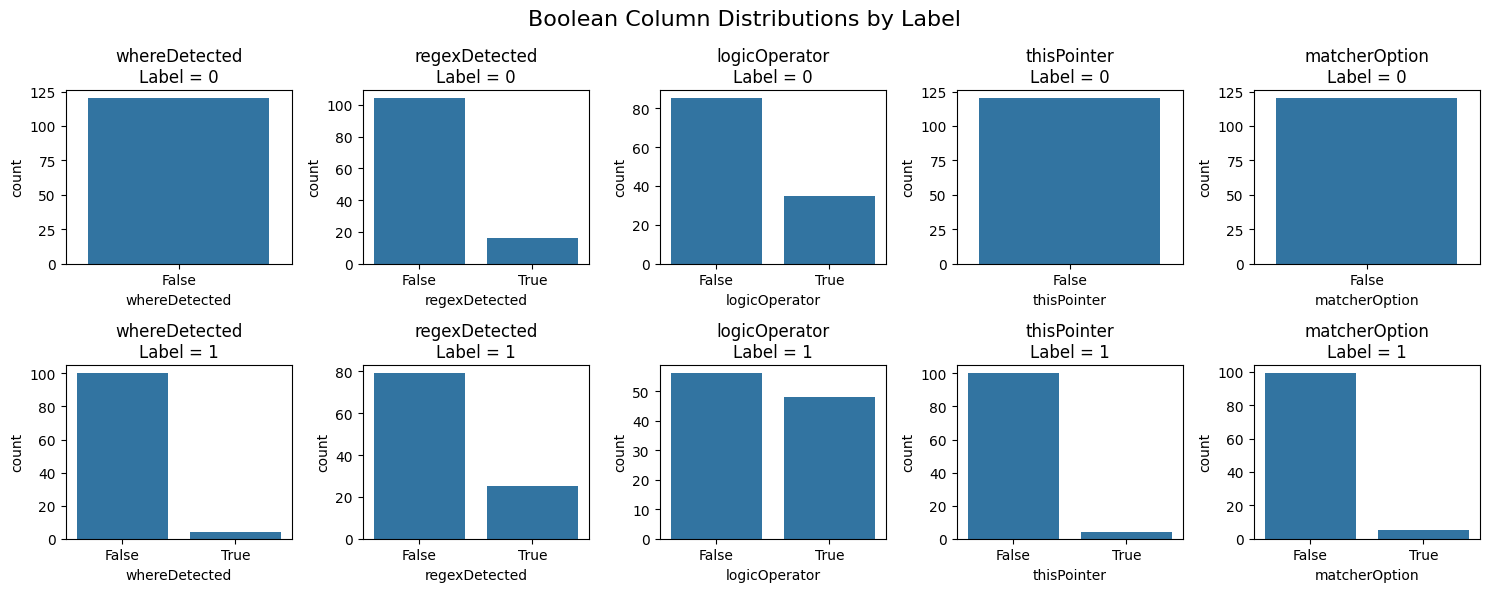

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Plot boolean columns as subplots
bool_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']
num_cols = len(bool_columns)
num_rows = 2  # One row for each label

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

for i, col in enumerate(bool_columns):
    sns.countplot(x=col, data=df_label_0, ax=axes[0][i])
    axes[0][i].set_title(f'{col}\nLabel = 0')
    sns.countplot(x=col, data=df_label_1, ax=axes[1][i])
    axes[1][i].set_title(f'{col}\nLabel = 1')

# Add subtitles
plt.suptitle('Boolean Column Distributions by Label', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


In [6]:
from scipy.stats import ks_2samp

# Split data by label
data_label_0 = data[data['label'] == 0]['planningTimeMicros']
data_label_1 = data[data['label'] == 1]['planningTimeMicros']

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(data_label_0, data_label_1)

from scipy.stats import shapiro

# Perform Shapiro-Wilk test for each group
shapiro_stat_0, p_value_0 = shapiro(data_label_0)
shapiro_stat_1, p_value_1 = shapiro(data_label_1)

# Print p-values
print("Shapiro-Wilk test p-value for data_label_0:", p_value_0)
print("Shapiro-Wilk test p-value for data_label_1:", p_value_1)


Shapiro-Wilk test p-value for data_label_0: 6.437833468078515e-14
Shapiro-Wilk test p-value for data_label_1: 4.567814832677313e-16


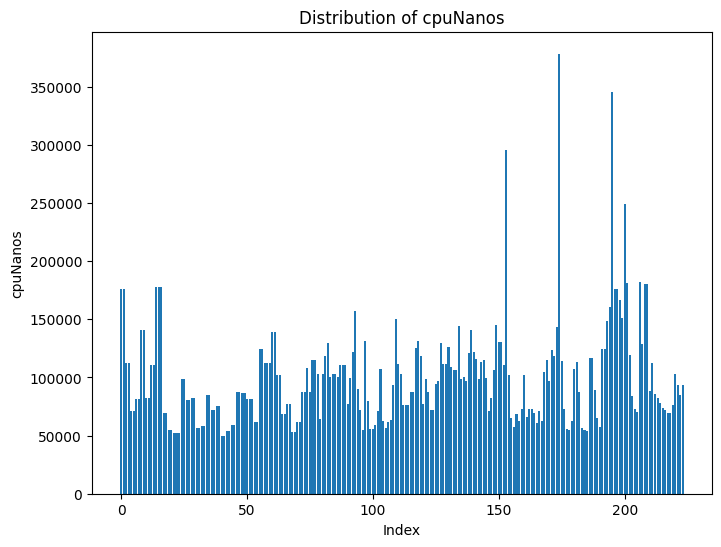

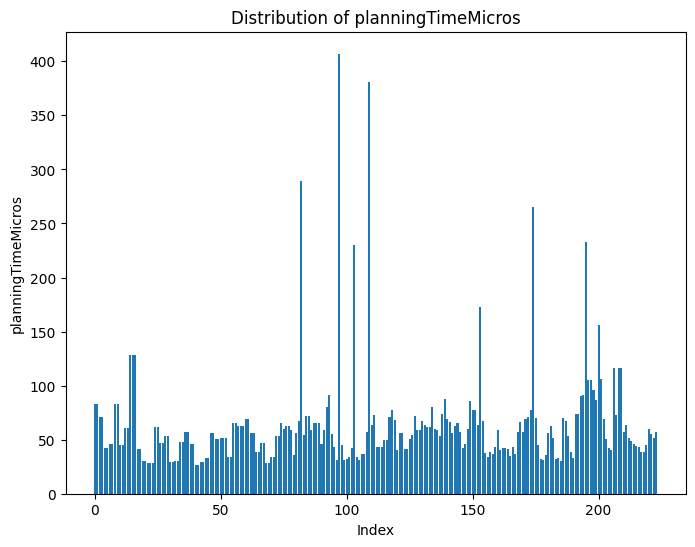

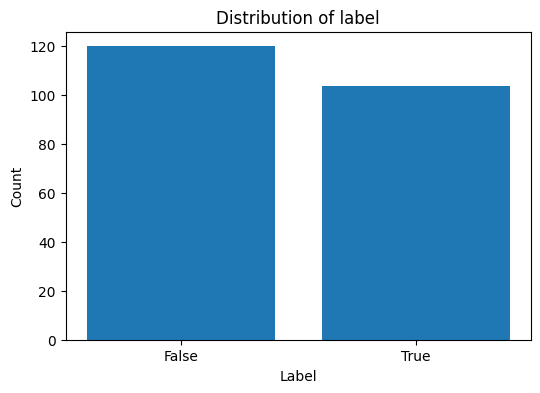

In [7]:
import matplotlib.pyplot as plt

# Plot distribution of cpuNanos
plt.figure(figsize=(8, 6))
plt.bar(data.index, data['cpuNanos'])
plt.title('Distribution of cpuNanos')
plt.xlabel('Index')
plt.ylabel('cpuNanos')
plt.show()

# Plot distribution of planningTimeMicros
plt.figure(figsize=(8, 6))
plt.bar(data.index, data['planningTimeMicros'])
plt.title('Distribution of planningTimeMicros')
plt.xlabel('Index')
plt.ylabel('planningTimeMicros')
plt.show()

# Plot distribution of label
plt.figure(figsize=(6, 4))
label_counts = data['label'].value_counts()
plt.bar(['False', 'True'], label_counts)
plt.title('Distribution of label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [8]:
# Compute descriptive statistics for label
label_stats = data['label'].describe()

# Additional descriptive statistics
label_counts = data['label'].value_counts()

# Print descriptive statistics for label
print("Descriptive Statistics for label:")
print(label_stats)
print("\nCounts for each unique value in label:")
print(label_counts)


Descriptive Statistics for label:
count       224
unique        2
top       False
freq        120
Name: label, dtype: object

Counts for each unique value in label:
label
False    120
True     104
Name: count, dtype: int64


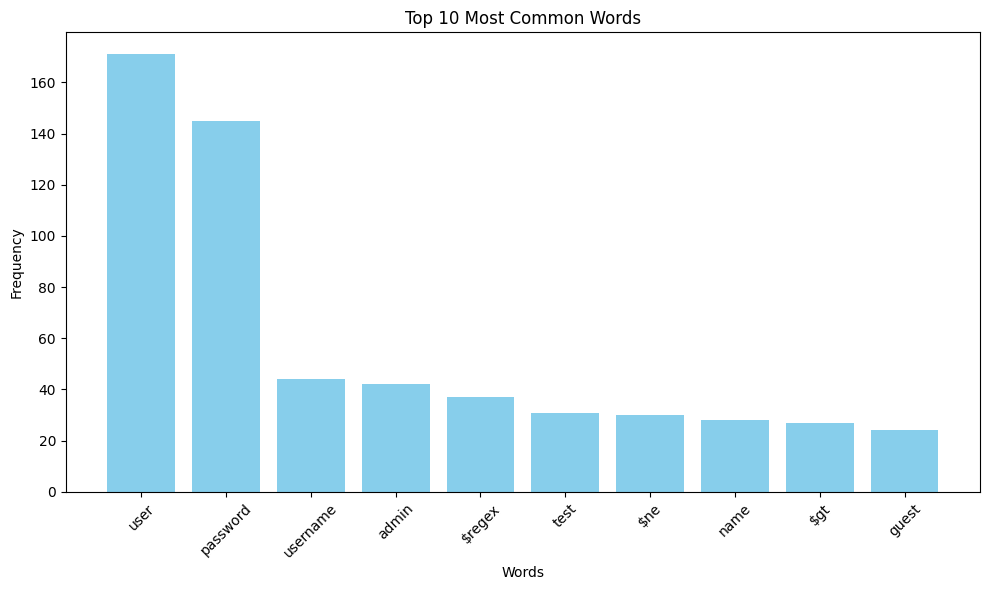

In [9]:
import re
from collections import Counter
import matplotlib.pyplot as plt

word_counts = Counter()
for text in data['filter_str']:
    tokens = mongoTokens.custom_tokenizer(text)
    word_counts.update(tokens)

# Convert the word counts to a DataFrame for easier manipulation
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Frequency'])

# Get the top 50 most common words
top_words = word_counts_df.sort_values(by='Frequency', ascending=False).head(10)

# Plot the top 50 most common words
plt.figure(figsize=(10, 6))
plt.bar(top_words.index, top_words['Frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export word frequency data to a CSV file
word_counts_df.to_csv('wordFreq.csv', header=True)

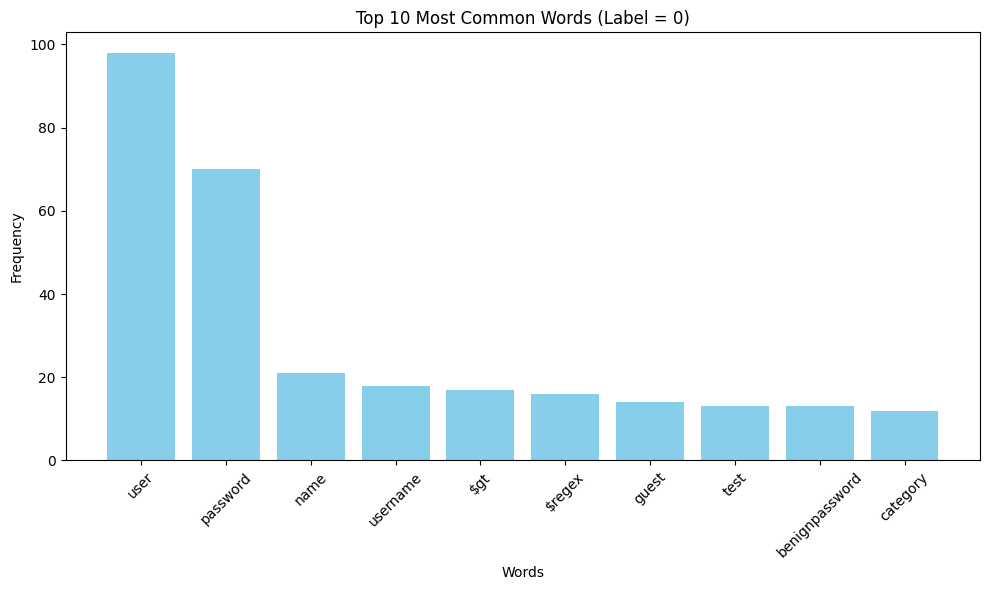

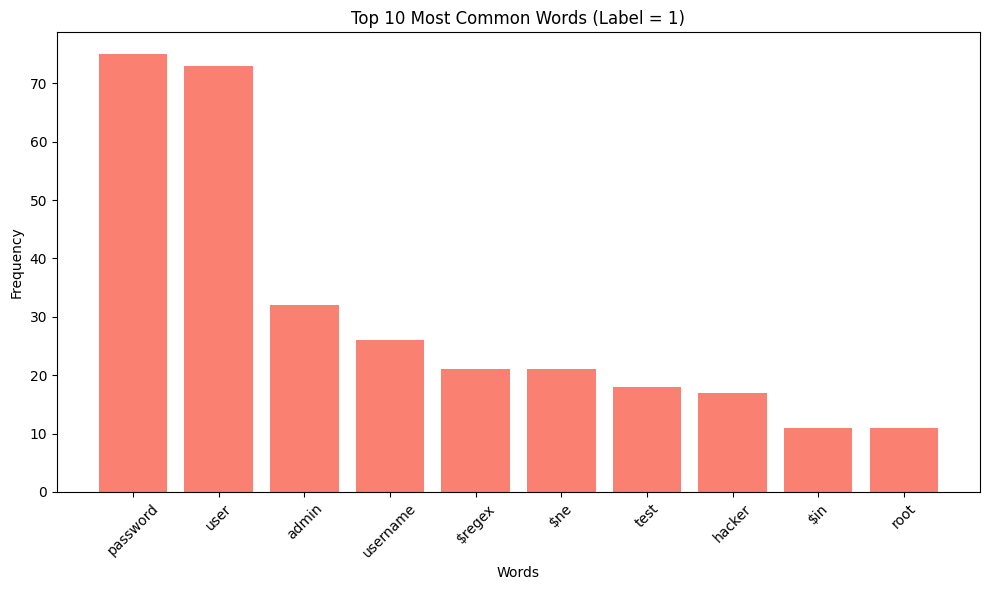

In [10]:
# Separate data based on label value
data_label_0 = data[data['label'] == 0]
data_label_1 = data[data['label'] == 1]

# Initialize Counters for each label value
word_counts_0 = Counter()
word_counts_1 = Counter()

# Update Counters with tokenized words for each label value
for text in data_label_0['filter_str']:
    tokens = mongoTokens.custom_tokenizer(text)
    word_counts_0.update(tokens)

for text in data_label_1['filter_str']:
    tokens = mongoTokens.custom_tokenizer(text)
    word_counts_1.update(tokens)

# Convert word counts to DataFrames for easier manipulation
word_counts_df_0 = pd.DataFrame.from_dict(word_counts_0, orient='index', columns=['Frequency'])
word_counts_df_1 = pd.DataFrame.from_dict(word_counts_1, orient='index', columns=['Frequency'])

# Get the top 10 most common words for each label value
top_words_0 = word_counts_df_0.sort_values(by='Frequency', ascending=False).head(10)
top_words_1 = word_counts_df_1.sort_values(by='Frequency', ascending=False).head(10)

# Plot the top 10 most common words for label = 0
plt.figure(figsize=(10, 6))
plt.bar(top_words_0.index, top_words_0['Frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words (Label = 0)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the top 10 most common words for label = 1
plt.figure(figsize=(10, 6))
plt.bar(top_words_1.index, top_words_1['Frequency'], color='salmon')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words (Label = 1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export word frequency data for each label value to CSV files
word_counts_df_0.to_csv('wordFreqLabel_0.csv', header=True)
word_counts_df_1.to_csv('wordFreqLabel_1.csv', header=True)


In [11]:

def dename_tokenizer(text):
    # Pass 1: Remove the word "name" from the input text
    text_without_name = re.sub(r"name", "", text)
    text_without_name = re.sub(r"''","",text_without_name)
    text_without_name = re.sub(r"this.","this'",text_without_name)
    text_without_name = re.sub(r"length","'length'",text_without_name)
    # Pass 2: Tokenize using regular expressions
    pattern_quotes = r"'(?:[^']|'')*'"
    tokens = re.findall(pattern_quotes, text_without_name)
    

    # Pass 3: Handle curly braces and colons
    processed_tokens = []
    for token in tokens:
        if token.startswith("'"):
            processed_tokens.append(token)
        else:
            processed_tokens.extend(re.split(r"([{}:])", token))

    # Remove empty strings from the list
    processed_tokens = [t for t in processed_tokens if t != ""]

    return processed_tokens

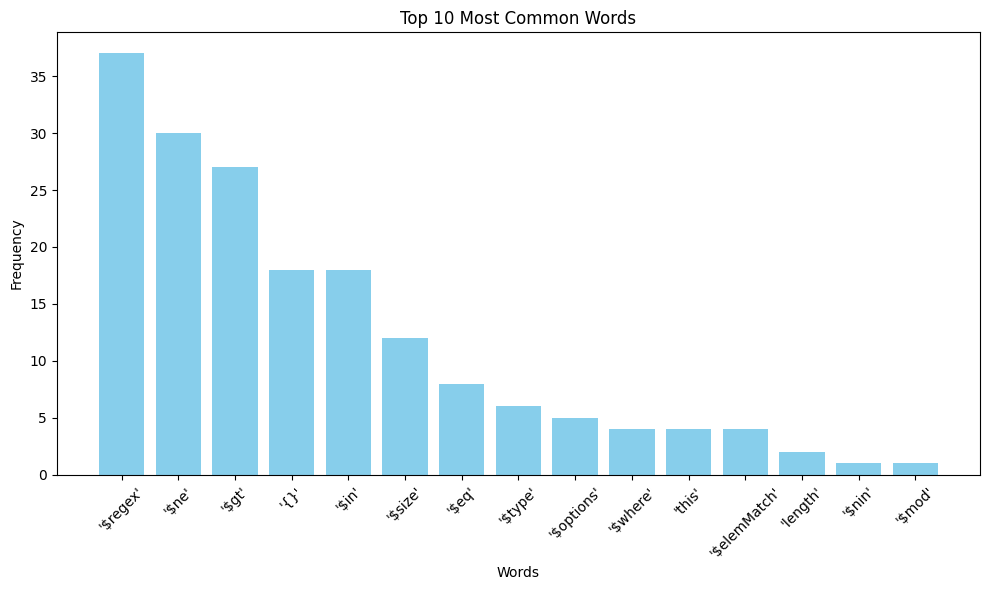

In [12]:
import re
from collections import Counter
import matplotlib.pyplot as plt

import mongoTokens

word_counts = Counter()
tokenized_lines = []

for text in data['denamed']:
    tokens = dename_tokenizer(text)
    tokenized_text = ' '.join(tokens)
    tokenized_lines.append(f"{text}, {tokenized_text}")  # Append original text and tokenized text separately
    word_counts.update(tokens)

# Convert the word counts to a DataFrame for easier manipulation
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Frequency'])

# Get the top 50 most common words
top_words = word_counts_df.sort_values(by='Frequency', ascending=False).head(100)

# Plot the top 50 most common words
plt.figure(figsize=(10, 6), facecolor='white')
plt.bar(top_words.index, top_words['Frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(False)
plt.show()

# Export word frequency data to a CSV file
word_counts_df.to_csv('wordFreqDN.csv', header=True)

# Export tokenized words to a text file
with open('tokenized_words.txt', 'w') as f:
    f.write('\n'.join(tokenized_lines))


In [13]:
import pandas as pd

# Descriptive statistics for cpuNanos
cpuNanos_stats = data['cpuNanos'].describe()

# Descriptive statistics for planningTimeMicros
planningTimeMicros_stats = data['planningTimeMicros'].describe()

# Combine the descriptive statistics into a single DataFrame
stats_df = pd.DataFrame({
    'cpuNanos': cpuNanos_stats,
    'planningTimeMicros': planningTimeMicros_stats
})

# Export to CSV
stats_df.to_csv('numFeatures.csv')


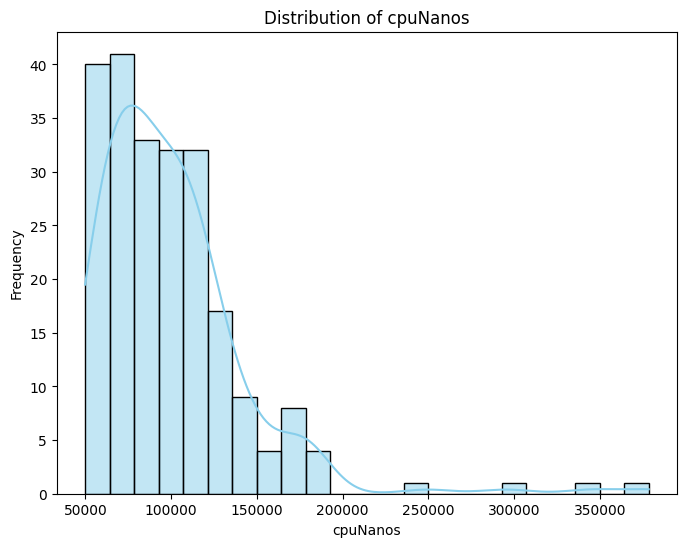

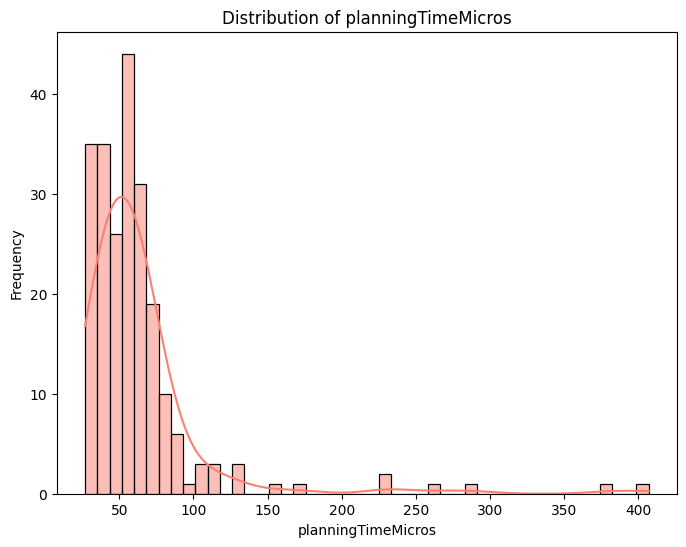

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of cpuNanos
plt.figure(figsize=(8, 6))
sns.histplot(data['cpuNanos'], kde=True, color='skyblue')
plt.title('Distribution of cpuNanos')
plt.xlabel('cpuNanos')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of planningTimeMicros
plt.figure(figsize=(8, 6))
sns.histplot(data['planningTimeMicros'], kde=True, color='salmon')
plt.title('Distribution of planningTimeMicros')
plt.xlabel('planningTimeMicros')
plt.ylabel('Frequency')
plt.show()


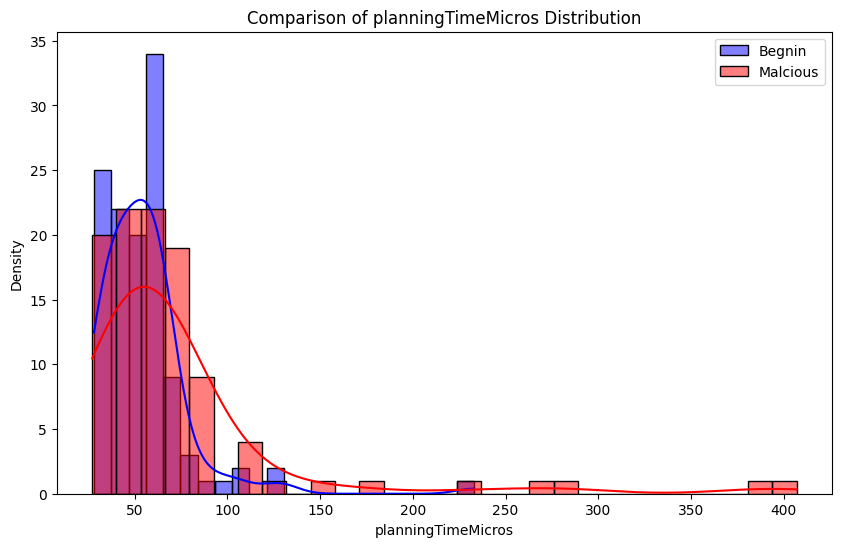

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels
sns.histplot(data=df_label_0, x='planningTimeMicros', color='blue', label='Begnin', kde=True)
sns.histplot(data=df_label_1, x='planningTimeMicros', color='red', label='Malcious', kde=True)

# Add labels and title
plt.title('Comparison of planningTimeMicros Distribution')
plt.xlabel('planningTimeMicros')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()



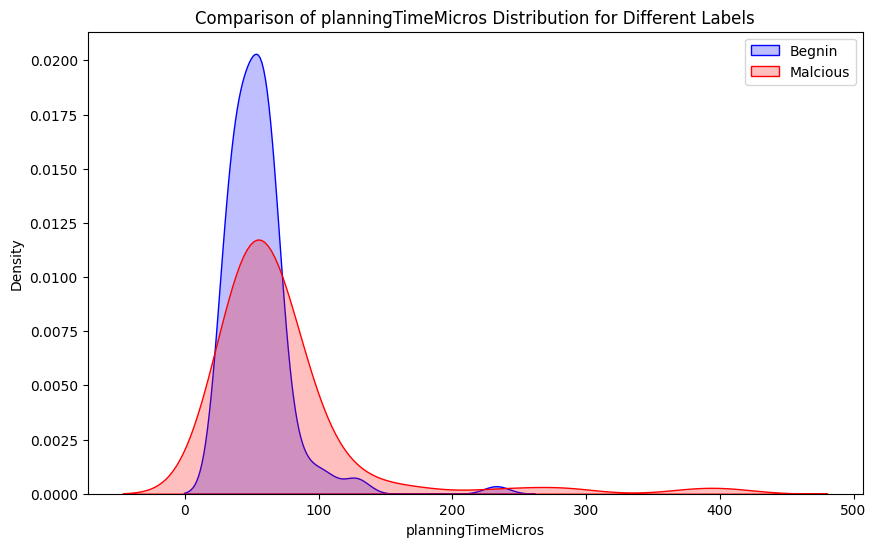

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels as area charts
sns.kdeplot(data=df_label_0, x='planningTimeMicros', color='blue', label='Begnin', fill=True)
sns.kdeplot(data=df_label_1, x='planningTimeMicros', color='red', label='Malcious', fill=True)

# Add labels and title
plt.title('Comparison of planningTimeMicros Distribution for Different Labels')
plt.xlabel('planningTimeMicros')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()


In [17]:
from scipy.stats import f_oneway

# Perform ANOVA for 'cpuNanos'
anova_cpu = f_oneway(data[data['label'] == 0]['cpuNanos'],
                     data[data['label'] == 1]['cpuNanos'])

# Perform ANOVA for 'planningTimeMicros'
anova_planning = f_oneway(data[data['label'] == 0]['planningTimeMicros'],
                          data[data['label'] == 1]['planningTimeMicros'])

# Print ANOVA results
print("ANOVA for 'cpuNanos':")
print("F-statistic:", anova_cpu.statistic)
print("P-value:", anova_cpu.pvalue)
print("\nANOVA for 'planningTimeMicros':")
print("F-statistic:", anova_planning.statistic)
print("P-value:", anova_planning.pvalue)


ANOVA for 'cpuNanos':
F-statistic: 5.161096143621489
P-value: 0.024056409160643322

ANOVA for 'planningTimeMicros':
F-statistic: 9.102090237063472
P-value: 0.0028510150496943235


In [18]:
import pandas as pd
from scipy import stats

# Sample data
data_label_0_cpu = data[data['label'] == 0]['planningTimeMicros']
data_label_1_cpu = data[data['label'] == 1]['planningTimeMicros']

# Perform t-test
alpha_levels = [0.01, 0.05, 0.1]
t_test_results = []

for alpha in alpha_levels:
    t_statistic, p_value = stats.ttest_ind(data_label_0_cpu, data_label_1_cpu, equal_var=False)
    significant = p_value < alpha
    t_test_results.append({'Alpha': alpha, 'T-Statistic': t_statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_t_test_results = pd.DataFrame(t_test_results)

# Display DataFrame
df_t_test_results


,Alpha,T-Statistic,P-Value,Significant
0,0.01,-2.864546,0.004862,True
1,0.05,-2.864546,0.004862,True
2,0.10,-2.864546,0.004862,True


In [19]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Sample data
data_label_0_cpu = data[data['label'] == 0]['planningTimeMicros']
data_label_1_cpu = data[data['label'] == 1]['planningTimeMicros']

# Perform Mann-Whitney U test
alpha_levels = [0.01, 0.05, 0.1]
mannwhitneyu_results = []

for alpha in alpha_levels:
    statistic, p_value = mannwhitneyu(data_label_0_cpu, data_label_1_cpu, alternative='two-sided')
    significant = p_value < alpha
    mannwhitneyu_results.append({'Alpha': alpha, 'Statistic': statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_mannwhitneyu_results = pd.DataFrame(mannwhitneyu_results)

# Display DataFrame
df_mannwhitneyu_results


,Alpha,Statistic,P-Value,Significant
0,0.01,4926.5,0.006628,True
1,0.05,4926.5,0.006628,True
2,0.10,4926.5,0.006628,True


In [20]:
from scipy.stats import ks_2samp

# Split data by label
data_label_0 = data[data['label'] == 0]['cpuNanos']
data_label_1 = data[data['label'] == 1]['cpuNanos']

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(data_label_0, data_label_1)

# Print p-value
print("Kolmogorov-Smirnov test p-value:", p_value)


Kolmogorov-Smirnov test p-value: 0.025984925043869716


In [21]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Calculate statistics for label 0
stats_label_0 = data[data['label'] == 0]['cpuNanos'].describe()
skewness_label_0 = skew(data[data['label'] == 0]['cpuNanos'])
kurtosis_label_0 = kurtosis(data[data['label'] == 0]['cpuNanos'])

# Calculate statistics for label 1
stats_label_1 = data[data['label'] == 1]['cpuNanos'].describe()
skewness_label_1 = skew(data[data['label'] == 1]['cpuNanos'])
kurtosis_label_1 = kurtosis(data[data['label'] == 1]['cpuNanos'])

# Combine statistics into a DataFrame
stats_df = pd.DataFrame({
    'Label 0': stats_label_0,
    'Label 1': stats_label_1
})

# Add skewness and kurtosis
stats_df.loc['Skewness'] = [skewness_label_0, skewness_label_1]
stats_df.loc['Kurtosis'] = [kurtosis_label_0, kurtosis_label_1]

# Print the DataFrame
stats_df


,Label 0,Label 1
count,120.000000,104.000000
mean,93480.683333,106751.576923
std,38591.197574,48755.307703
min,52048.000000,49784.000000
25%,69190.000000,72967.000000
50%,85741.000000,99327.000000
75%,110362.250000,124534.000000
max,345429.000000,378420.000000
Skewness,2.795571,2.499541
Kurtosis,13.917899,9.888758


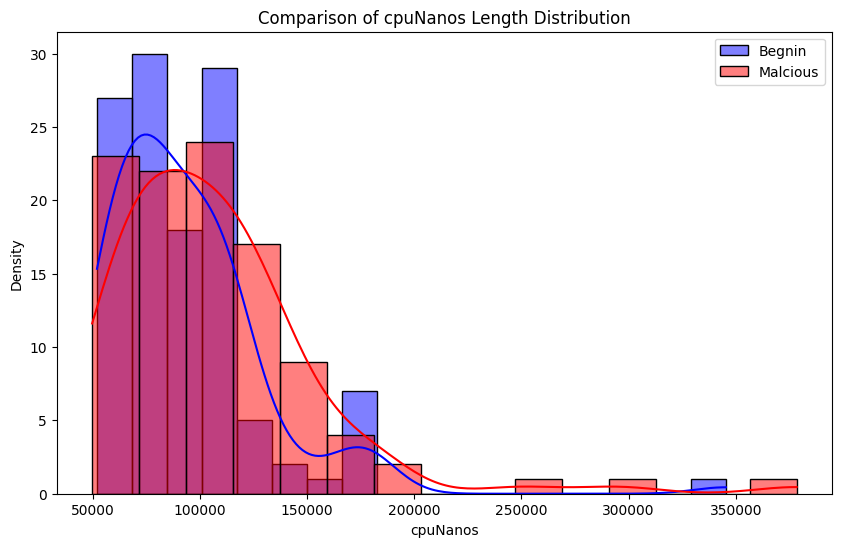

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels
sns.histplot(data=df_label_0, x='cpuNanos', color='blue', label='Begnin', kde=True)
sns.histplot(data=df_label_1, x='cpuNanos', color='red', label='Malcious', kde=True)

# Add labels and title
plt.title('Comparison of cpuNanos Length Distribution')
plt.xlabel('cpuNanos')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()


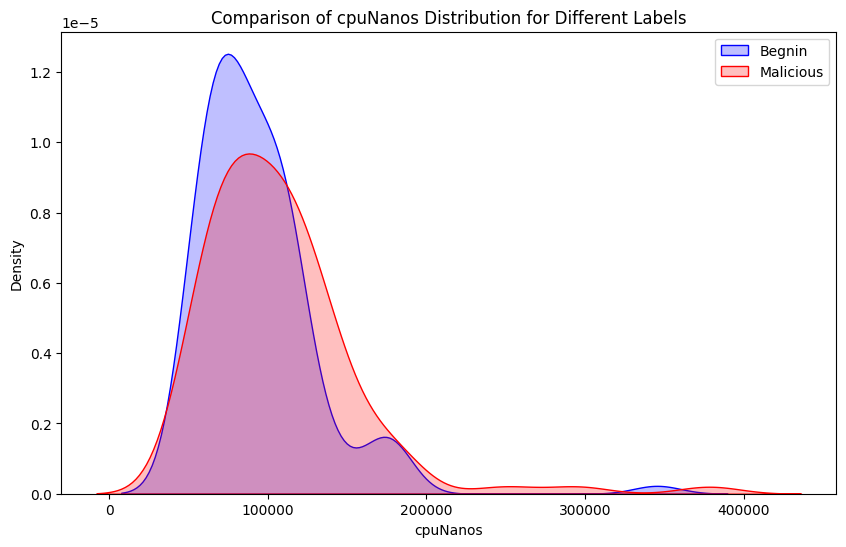

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot cpuNanos distribution for both labels as area charts
sns.kdeplot(data=df_label_0, x='cpuNanos', color='blue', label='Begnin', fill=True)
sns.kdeplot(data=df_label_1, x='cpuNanos', color='red', label='Malicious', fill=True)

# Add labels and title
plt.title('Comparison of cpuNanos Distribution for Different Labels')
plt.xlabel('cpuNanos')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()


In [24]:
import pandas as pd
from scipy import stats

# Sample data
data_label_0_cpu = data[data['label'] == 0]['cpuNanos']
data_label_1_cpu = data[data['label'] == 1]['cpuNanos']

# Perform t-test
alpha_levels = [0.01, 0.05, 0.1]
t_test_results = []

for alpha in alpha_levels:
    t_statistic, p_value = stats.ttest_ind(data_label_0_cpu, data_label_1_cpu, equal_var=False)
    significant = p_value < alpha
    t_test_results.append({'Alpha': alpha, 'T-Statistic': t_statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_t_test_results = pd.DataFrame(t_test_results)

# Display DataFrame
df_t_test_results


,Alpha,T-Statistic,P-Value,Significant
0,0.01,-2.234676,0.026571,False
1,0.05,-2.234676,0.026571,True
2,0.10,-2.234676,0.026571,True


In [25]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Sample data
data_label_0_cpu = data[data['label'] == 0]['cpuNanos']
data_label_1_cpu = data[data['label'] == 1]['cpuNanos']

# Perform Mann-Whitney U test
alpha_levels = [0.01, 0.05, 0.1]
mannwhitneyu_results = []

for alpha in alpha_levels:
    statistic, p_value = mannwhitneyu(data_label_0_cpu, data_label_1_cpu, alternative='two-sided')
    significant = p_value < alpha
    mannwhitneyu_results.append({'Alpha': alpha, 'Statistic': statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_mannwhitneyu_results = pd.DataFrame(mannwhitneyu_results)

# Display DataFrame
df_mannwhitneyu_results


,Alpha,Statistic,P-Value,Significant
0,0.01,5013.0,0.011228,False
1,0.05,5013.0,0.011228,True
2,0.10,5013.0,0.011228,True


In [26]:
from scipy.stats import f_oneway

# Perform ANOVA for 'cpuNanos'
anova_cpu = f_oneway(data[data['label'] == 0]['cpuNanos'],
                     data[data['label'] == 1]['cpuNanos'])

# Perform ANOVA for 'planningTimeMicros'
anova_planning = f_oneway(data[data['label'] == 0]['planningTimeMicros'],
                          data[data['label'] == 1]['planningTimeMicros'])

# Print ANOVA results
print("ANOVA for 'cpuNanos':")
print("F-statistic:", anova_cpu.statistic)
print("P-value:", anova_cpu.pvalue)
print("\nANOVA for 'planningTimeMicros':")
print("F-statistic:", anova_planning.statistic)
print("P-value:", anova_planning.pvalue)


ANOVA for 'cpuNanos':
F-statistic: 5.161096143621489
P-value: 0.024056409160643322

ANOVA for 'planningTimeMicros':
F-statistic: 9.102090237063472
P-value: 0.0028510150496943235


In [27]:
import pandas as pd

# Define function to calculate conditional probabilities
def calculate_conditional_probabilities(data, feature, label_value):
    total_samples = len(data)
    feature_present = len(data[data[feature]])  # Number of samples where the feature is present
    feature_absent = total_samples - feature_present  # Number of samples where the feature is absent
    
    label_present = len(data[(data[feature]) & (data['label'] == label_value)])  # Number of samples where the feature is present and label is the specified value
    label_absent = feature_present - label_present  # Number of samples where the feature is present and label is not the specified value
    
    conditional_probability = label_present / feature_present  # P(label|feature)
    return conditional_probability

# Define boolean columns
bool_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']
conditional_probabilities = []

# Calculate conditional probabilities for each boolean column
for col in bool_columns:
    # Probability of label being 1 given the feature is present
    prob_label_1_given_present = calculate_conditional_probabilities(data, col, 1)
    
    # Probability of label being 1 given the feature is absent
    prob_label_1_given_absent = 1 - prob_label_1_given_present
    
    # Probability of label being 0 given the feature is present
    prob_label_0_given_present = calculate_conditional_probabilities(data, col, 0)
    
    # Probability of label being 0 given the feature is absent
    prob_label_0_given_absent = 1 - prob_label_0_given_present
    
    conditional_probabilities.append({'Feature': col,
                                      'P(Label=1|Feature=1)': prob_label_1_given_present,
                                      'P(Label=1|Feature=0)': prob_label_1_given_absent,
                                      'P(Label=0|Feature=1)': prob_label_0_given_present,
                                      'P(Label=0|Feature=0)': prob_label_0_given_absent})

# Create DataFrame from conditional probabilities
df_conditional_probabilities = pd.DataFrame(conditional_probabilities)

# Display DataFrame
df_conditional_probabilities


,Feature,P(Label=1|Feature=1),P(Label=1|Feature=0),P(Label=0|Feature=1),P(Label=0|Feature=0)
0,whereDetected,1.000000,0.000000,0.000000,1.000000
1,regexDetected,0.609756,0.390244,0.390244,0.609756
2,logicOperator,0.578313,0.421687,0.421687,0.578313
3,thisPointer,1.000000,0.000000,0.000000,1.000000
4,matcherOption,1.000000,0.000000,0.000000,1.000000


In [28]:
from scipy.stats import pointbiserialr
bool_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']
# Define list to store correlation results
correlation_results = []

# Calculate correlation for each boolean column
for col in bool_columns:
    # Calculate correlation coefficient and p-value
    correlation, p_value = pointbiserialr(data[col], data['label'])
    
    # Append results to correlation_results list
    correlation_results.append({'Feature': col, 'Correlation': correlation, 'P-Value': p_value})

# Create DataFrame from correlation results
df_correlation_results = pd.DataFrame(correlation_results)

# Display DataFrame
print(df_correlation_results)


         Feature  Correlation   P-Value
0  whereDetected     0.144841  0.030227
1  regexDetected     0.138064  0.038952
2  logicOperator     0.175420  0.008508
3    thisPointer     0.144841  0.030227
4  matcherOption     0.162307  0.015026


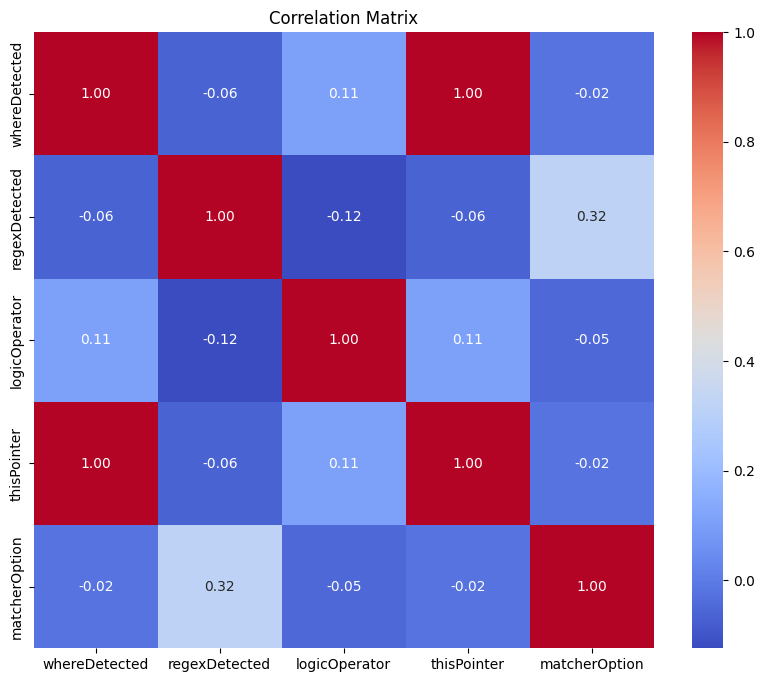

In [29]:
# Remove 'label' from bool_columns if it's included
if 'label' in bool_columns:
    bool_columns.remove('label')
bool_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']
# Calculate correlation matrix
correlation_matrix = data[bool_columns].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [30]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Initialize DataFrame to store VIF values
vif_values = []
bool_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']
for col in bool_columns:
    data[col] = data[col].astype(int)
# Iterate through boolean columns
for col in bool_columns:
    # Fit logistic regression model
    X = sm.add_constant(data[col])  # Add constant for intercept
    y = data['label']
    model = sm.Logit(y, X)
    result = model.fit()

    # Compute VIF
    vif = 1 / (1 - result.prsquared)
    
    # Append VIF to list
    vif_values.append({'Feature': col, 'VIF': vif})

# Create DataFrame from list of dictionaries
vif_data = pd.DataFrame(vif_values)

# Display DataFrame
print(vif_data)

         Current function value: 0.676706
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.681054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675174
         Iterations 4
         Current function value: 0.676706
         Iterations: 35
         Current function value: 0.673173
         Iterations: 35
         Feature       VIF
0  whereDetected  1.020524
1  regexDetected  1.014008
2  logicOperator  1.022838
3    thisPointer  1.020524
4  matcherOption  1.025878


/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
from scipy.stats import pointbiserialr

# Extract the target variable
target_variable = data['label']

# Dictionary to store correlation coefficients
correlation_coefficients = {}

# Iterate over boolean columns
for col in bool_columns:
    # Compute Point-Biserial Correlation Coefficient
    corr_coefficient, p_value = pointbiserialr(data[col], target_variable)
    # Store the correlation coefficient and p-value in the dictionary
    correlation_coefficients[col] = {'Point-Biserial Correlation Coefficient': corr_coefficient, 'P-value': p_value}

# Print the correlation coefficients
for col, values in correlation_coefficients.items():
    print(f"{col}:")
    print(f"  Point-Biserial Correlation Coefficient: {values['Point-Biserial Correlation Coefficient']}")
    print(f"  P-value: {values['P-value']}")


whereDetected:
  Point-Biserial Correlation Coefficient: 0.1448413648755803
  P-value: 0.030227277776885803
regexDetected:
  Point-Biserial Correlation Coefficient: 0.13806439439117632
  P-value: 0.03895176663531335
logicOperator:
  Point-Biserial Correlation Coefficient: 0.17542034699441184
  P-value: 0.008508469655423527
thisPointer:
  Point-Biserial Correlation Coefficient: 0.1448413648755803
  P-value: 0.030227277776885803
matcherOption:
  Point-Biserial Correlation Coefficient: 0.16230686829029883
  P-value: 0.015026401147954022


In [32]:
from scipy.stats import chi2_contingency
import numpy as np

# Dictionary to store phi coefficients
phi_coefficients = {}

# Iterate over boolean columns
for col in bool_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(data[col], data['label'])
    # Compute chi-square statistic, p-value, degrees of freedom, and expected frequencies
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    # Compute phi coefficient
    phi_coefficient = np.sqrt(chi2_stat / len(data))
    # Store the phi coefficient in the dictionary
    phi_coefficients[col] = {'Phi Coefficient': phi_coefficient, 'P-value': p_val}

# Print the phi coefficients
for col, values in phi_coefficients.items():
    print(f"{col}:")
    print(f"  Phi Coefficient: {values['Phi Coefficient']}")
    print(f"  P-value: {values['P-value']}")


whereDetected:
  Phi Coefficient: 0.11104504640461153
  P-value: 0.09651877524572479
regexDetected:
  Phi Coefficient: 0.12649013378353274
  P-value: 0.0583404540344552
logicOperator:
  Phi Coefficient: 0.16615285696451834
  P-value: 0.012891658723005529
thisPointer:
  Phi Coefficient: 0.11104504640461153
  P-value: 0.09651877524572479
matcherOption:
  Phi Coefficient: 0.13200958620944309
  P-value: 0.04818439372092508


In [33]:
import numpy as np

# Define a function to calculate IV
def calculate_iv(feature, target):
    """
    Calculate Information Value (IV) for a given feature and target.
    
    Parameters:
    - feature: Pandas Series, the feature column
    - target: Pandas Series, the target column
    
    Returns:
    - IV: float, Information Value
    """
    # Define bins (unique values) for the feature
    bins = np.unique(feature)
    iv = 0
    # Loop through bins and calculate IV for each bin
    for bin in bins:
        # Calculate the proportion of positive and negative class instances in the bin
        positive = len(feature[(feature == bin) & (target == 1)])
        negative = len(feature[(feature == bin) & (target == 0)])
        # Calculate the proportion of positive and negative class instances in the entire dataset
        p = positive / sum(target)
        q = negative / (len(target) - sum(target))
        # Calculate IV for the bin and add it to the total IV
        if p == 0 or q == 0:
            iv += 0
        else:
            iv += (p - q) * np.log(p / q)
    return iv

# Dictionary to store IV values
iv_values = {}

# Iterate over boolean columns
for col in bool_columns:
    # Calculate IV for the column
    iv = calculate_iv(data[col], data['label'])
    # Store the IV value in the dictionary
    iv_values[col] = iv

# Print the IV values
for col, iv in iv_values.items():
    print(f"{col}: IV = {iv}")


whereDetected: IV = 0.001508488967433894
regexDetected: IV = 0.0772086121368992
logicOperator: IV = 0.12454193366731783
thisPointer: IV = 0.001508488967433894
matcherOption: IV = 0.002368800433018406


In [34]:
from scipy.stats import chi2_contingency

# Define boolean columns
bool_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']

# Initialize list to store chi-square test results
chi2_results = []

# Iterate through boolean columns
for col in bool_columns:
    # Create contingency table
    contingency_table = pd.crosstab(data[col], data['label'])
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Append results to list
    chi2_results.append({'Feature': col, 'Chi-square Statistic': chi2_stat, 'P-value': p_value})

# Create DataFrame from list of dictionaries
chi2_results_df = pd.DataFrame(chi2_results)

# Display DataFrame
print(chi2_results_df)


         Feature  Chi-square Statistic   P-value
0  whereDetected              2.762145  0.096519
1  regexDetected              3.583945  0.058340
2  logicOperator              6.183917  0.012892
3    thisPointer              2.762145  0.096519
4  matcherOption              3.903543  0.048184


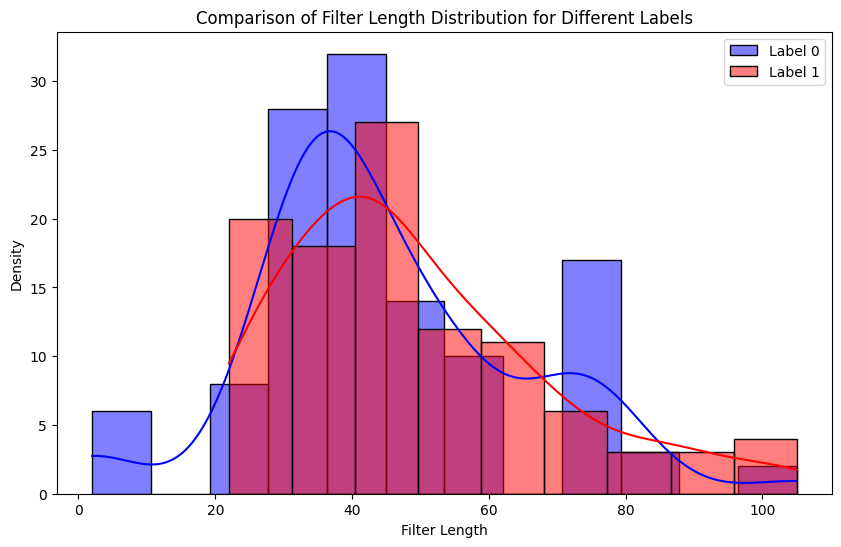

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels
sns.histplot(data=df_label_0, x='queryLength', color='blue', label='Label 0', kde=True)
sns.histplot(data=df_label_1, x='queryLength', color='red', label='Label 1', kde=True)

# Add labels and title
plt.title('Comparison of Filter Length Distribution for Different Labels')
plt.xlabel('Filter Length')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()


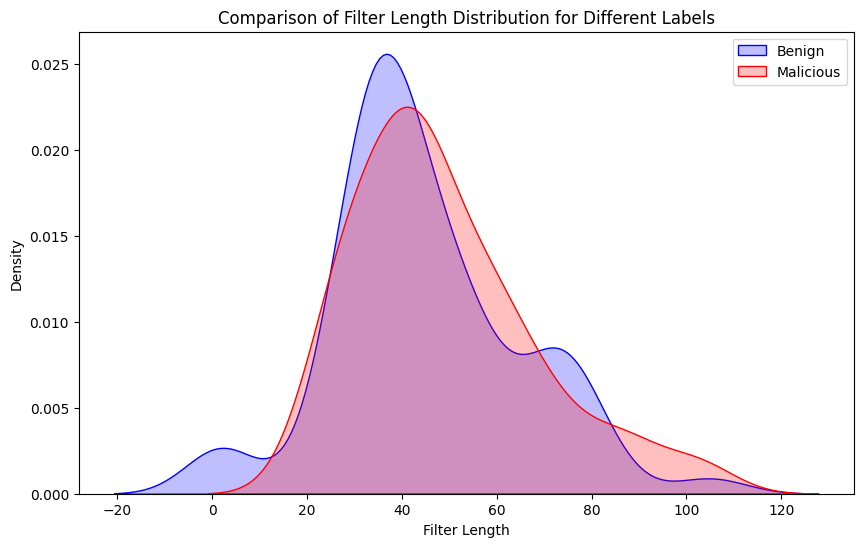

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels as area charts
sns.kdeplot(data=df_label_0, x='queryLength', color='blue', label='Benign', fill=True)
sns.kdeplot(data=df_label_1, x='queryLength', color='red', label='Malicious', fill=True)

# Add labels and title
plt.title('Comparison of Filter Length Distribution for Different Labels')
plt.xlabel('Filter Length')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()


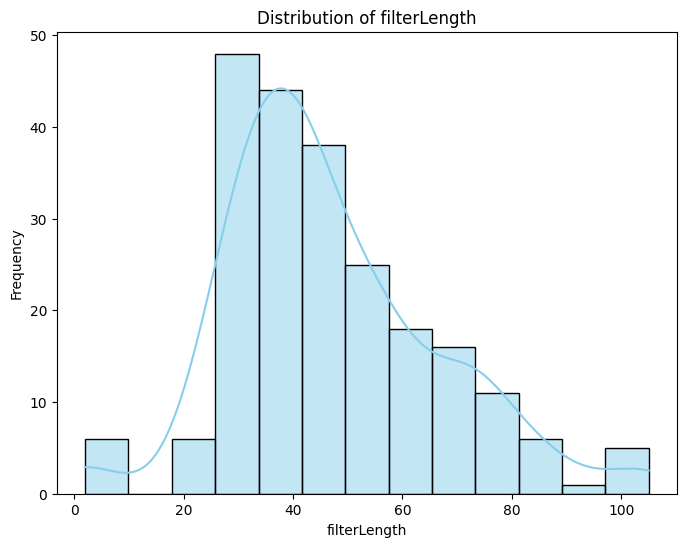

In [37]:
plt.figure(figsize=(8, 6))
sns.histplot(data['queryLength'], kde=True, color='skyblue', line_kws={'color':'red'})
plt.title('Distribution of filterLength')
plt.xlabel('filterLength')
plt.ylabel('Frequency')
plt.show()

In [38]:
data['queryLength'].describe()

count    224.000000
mean      46.776786
std       19.571971
min        2.000000
25%       33.000000
50%       43.000000
75%       58.000000
max      105.000000
Name: queryLength, dtype: float64

In [39]:
import pandas as pd
from scipy import stats

# Sample data
data_label_0_cpu = data[data['label'] == 0]['queryLength']
data_label_1_cpu = data[data['label'] == 1]['queryLength']

# Perform t-test
alpha_levels = [0.01, 0.05, 0.1]
t_test_results = []

for alpha in alpha_levels:
    t_statistic, p_value = stats.ttest_ind(data_label_0_cpu, data_label_1_cpu, equal_var=False)
    significant = p_value < alpha
    t_test_results.append({'Alpha': alpha, 'T-Statistic': t_statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_t_test_results = pd.DataFrame(t_test_results)

# Display DataFrame
df_t_test_results

,Alpha,T-Statistic,P-Value,Significant
0,0.01,-1.514076,0.13145,False
1,0.05,-1.514076,0.13145,False
2,0.10,-1.514076,0.13145,False


In [40]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Sample data
data_label_0_cpu = data[data['label'] == 0]['queryLength']
data_label_1_cpu = data[data['label'] == 1]['queryLength']

# Perform Mann-Whitney U test
alpha_levels = [0.01, 0.05, 0.1]
mannwhitneyu_results = []

for alpha in alpha_levels:
    statistic, p_value = mannwhitneyu(data_label_0_cpu, data_label_1_cpu, alternative='two-sided')
    significant = p_value < alpha
    mannwhitneyu_results.append({'Alpha': alpha, 'Statistic': statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_mannwhitneyu_results = pd.DataFrame(mannwhitneyu_results)

# Display DataFrame
df_mannwhitneyu_results


,Alpha,Statistic,P-Value,Significant
0,0.01,5589.0,0.178336,False
1,0.05,5589.0,0.178336,False
2,0.10,5589.0,0.178336,False


In [41]:
from scipy.stats import ks_2samp

# Split data by label
data_label_0 = data[data['label'] == 0]['queryLength']
data_label_1 = data[data['label'] == 1]['queryLength']

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(data_label_0, data_label_1)

from scipy.stats import shapiro

# Perform Shapiro-Wilk test for each group
shapiro_stat_0, p_value_0 = shapiro(data_label_0)
shapiro_stat_1, p_value_1 = shapiro(data_label_1)

# Print p-values
print("Shapiro-Wilk test p-value for data_label_0:", p_value_0)
print("Shapiro-Wilk test p-value for data_label_1:", p_value_1)


Shapiro-Wilk test p-value for data_label_0: 3.34472137740307e-05
Shapiro-Wilk test p-value for data_label_1: 1.5998851432273655e-05


In [42]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
# Drop non-numeric columns that are not relevant for PCA and LDA
numeric_data = data.drop(columns=['filter_str','denamed'])

# Encode boolean columns as integers
bool_columns = ['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']
numeric_data[bool_columns] = numeric_data[bool_columns].astype(int)

# Separate features and target variable
X = numeric_data.drop(columns=['label'])
y = numeric_data['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Perform LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=min(X_scaled.shape[1], len(np.unique(y)) - 1))
X_lda = lda.fit_transform(X_scaled, y)

# Print explained variance ratio for PCA
print("Explained Variance Ratio (PCA):", pca.explained_variance_ratio_)

# Print explained variance ratio for LDA
print("Explained Variance Ratio (LDA):", lda.explained_variance_ratio_)


Explained Variance Ratio (PCA): [0.32469254 0.17416483]
Explained Variance Ratio (LDA): [1.]


In [43]:
import numpy as np

# Get the unique target class labels
targets = np.unique(y)

# Initialize counters
total_points = 0
overlapping_points = 0

# Iterate over the data points
for i in range(X_lda.shape[0]):
    # Count total points
    total_points += 1
    
    # Check for overlapping points
    for j in range(X_lda.shape[0]):
        if i != j and y[i] != y[j] and np.array_equal(X_lda[i], X_lda[j]):
            overlapping_points += 1
            break

# Divide by 2 to avoid double-counting overlapping points
overlapping_points //= 2

# Calculate the percentage of overlapped data
overlapped_percentage = (overlapping_points / total_points) * 100

print(f"Number of total points: {total_points}")
print(f"Number of overlapping points: {overlapping_points}")
print(f"Percentage of overlapped data: {overlapped_percentage:.2f}%")

Number of total points: 224
Number of overlapping points: 10
Percentage of overlapped data: 4.46%


/tmp/ipykernel_17504/3062013095.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['planningTimeMicros'] = scaler.fit_transform(X[['planningTimeMicros']])
/tmp/ipykernel_17504/3062013095.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']] = X[['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']].astype(int)


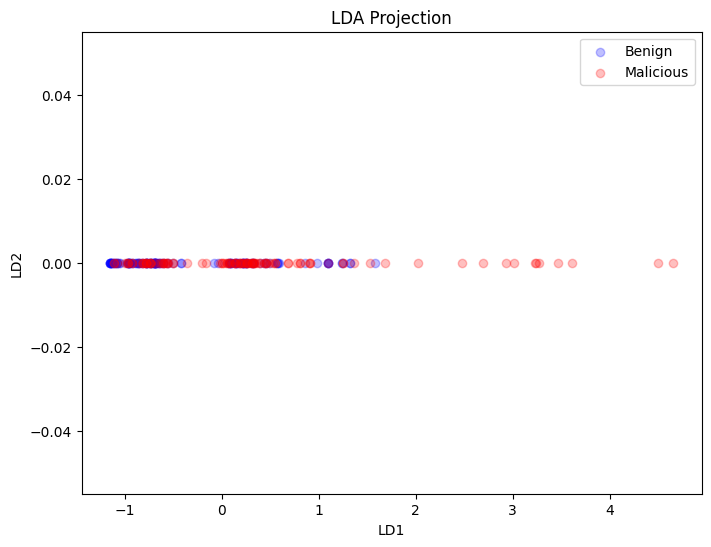

Explained Variance Ratio (LDA): [1.]
LDA Components:
[[ 0.62255255]
 [-0.14364473]
 [ 0.91289373]
 [ 1.22743314]
 [-0.14364473]
 [ 3.05617243]]


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt

# Separate features and target variable
X = data[['planningTimeMicros', 'whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']]
y = data['label']

# Standardize floating-point feature
scaler = StandardScaler()
X['planningTimeMicros'] = scaler.fit_transform(X[['planningTimeMicros']])

# Encode boolean features as integers
X[['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']] = X[['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']].astype(int)

# Perform LDA
lda = LinearDiscriminantAnalysis(n_components=min(X.shape[1], len(np.unique(y)) - 1))
X_lda = lda.fit_transform(X, y)

# Plot LDA
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['b', 'r']  # Assuming binary target classes
for target, color in zip(targets, colors):
    class_label = 'Benign' if target == 0 else 'Malicious'
    plt.scatter(X_lda[y == target], np.zeros_like(X_lda[y == target]), c=color, label=class_label, alpha=0.25)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA Projection')
plt.legend()
plt.show()

# Return LDA results
print("Explained Variance Ratio (LDA):", lda.explained_variance_ratio_)

lda_components = lda.scalings_

print("LDA Components:")
print(lda_components)


In [45]:
import numpy as np

# Get the unique target class labels
targets = np.unique(y)

# Initialize counters
total_points = 0
overlapping_points = 0

# Iterate over the data points
for i in range(X_lda.shape[0]):
    # Count total points
    total_points += 1
    
    # Check for overlapping points
    for j in range(X_lda.shape[0]):
        if i != j and y[i] != y[j] and np.array_equal(X_lda[i], X_lda[j]):
            overlapping_points += 1
            break

# Divide by 2 to avoid double-counting overlapping points
overlapping_points //= 2

# Calculate the percentage of overlapped data
overlapped_percentage = (overlapping_points / total_points) * 100

print(f"Number of total points: {total_points}")
print(f"Number of overlapping points: {overlapping_points}")
print(f"Percentage of overlapped data: {overlapped_percentage:.2f}%")

Number of total points: 224
Number of overlapping points: 44
Percentage of overlapped data: 19.64%


Principal Component Labels:
Component 1: whereDetected, thisPointer, planningTimeMicros
Component 2: regexDetected, matcherOption, planningTimeMicros


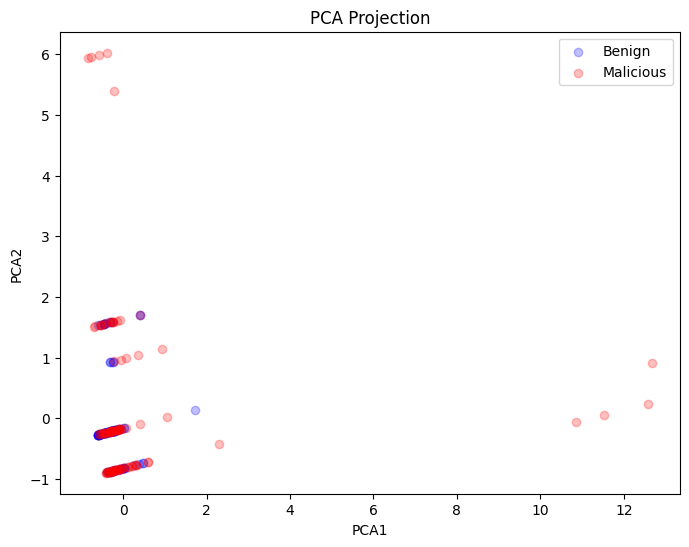

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get original feature names
feature_names = X.columns

# Get principal component loadings
component_loadings = pd.DataFrame(pca.components_, columns=feature_names)

# Label principal components based on loadings
component_labels = []
for i in range(len(component_loadings)):
    top_features = component_loadings.iloc[i].sort_values(ascending=False).index[:3]  # Top 3 features with highest loading
    component_labels.append(', '.join(top_features))

# Print component labels
print("Principal Component Labels:")
for i, label in enumerate(component_labels):
    print(f"Component {i+1}: {label}")

# Plot PCA with component names
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['b', 'r']  # Assuming binary target classes

for target, color in zip(targets, colors):
    class_label = 'Benign' if target == 0 else 'Malicious'
    plt.scatter(X_pca[y == target, 0], X_pca[y == target, 1], c=color, label=class_label, alpha=0.25)  # Set alpha to 0.5 for transparency

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Projection')
plt.legend()

plt.show()


In [47]:
import numpy as np

# Get the unique target class labels
targets = np.unique(y)

# Initialize counters
total_points = 0
overlapping_points = 0

# Iterate over the data points
for i in range(X_pca.shape[0]):
    # Count total points
    total_points += 1
    
    # Check for overlapping points
    for j in range(X_pca.shape[0]):
        if i != j and y[i] != y[j] and np.array_equal(X_pca[i], X_pca[j]):
            overlapping_points += 1
            break

# Divide by 2 to avoid double-counting overlapping points
overlapping_points //= 2

# Calculate the percentage of overlapped data
overlapped_percentage = (overlapping_points / total_points) * 100

print(f"Number of total points: {total_points}")
print(f"Number of overlapping points: {overlapping_points}")
print(f"Percentage of overlapped data: {overlapped_percentage:.2f}%")

Number of total points: 224
Number of overlapping points: 42
Percentage of overlapped data: 18.75%


t-SNE Transformed Coordinates:
[[  34.007023   -70.04964  ]
 [  25.449406   -76.12057  ]
 [ -17.9388       4.870971 ]
 [ -17.9388       4.870971 ]
 [-135.00873    -31.613256 ]
 [-135.00873    -31.613256 ]
 [-123.93289    -41.796474 ]
 [-123.93289    -41.796474 ]
 [ -65.129906   -75.90672  ]
 [ -65.129906   -75.90672  ]
 [  72.05084     65.38883  ]
 [  72.05084     65.38883  ]
 [  82.78293    -27.288242 ]
 [  82.78293    -27.288242 ]
 [  -9.461053   -43.835133 ]
 [  -9.461053   -43.835133 ]
 [  -9.461053   -43.835133 ]
 [-126.88751    -20.953669 ]
 [-126.88751    -20.953669 ]
 [-165.15546     -4.598903 ]
 [-165.15546     -4.598903 ]
 [  22.560907   117.976845 ]
 [  22.560907   117.976845 ]
 [  22.560907   117.976845 ]
 [  94.55954    -38.593586 ]
 [  84.77446    -36.709335 ]
 [-111.632645   -37.624283 ]
 [-111.632645   -37.624283 ]
 [ -61.556797   -12.744557 ]
 [ -61.556797   -12.744557 ]
 [  31.525688   125.46766  ]
 [  41.469795   122.63513  ]
 [  34.524044   114.03617  ]
 [  34.52404

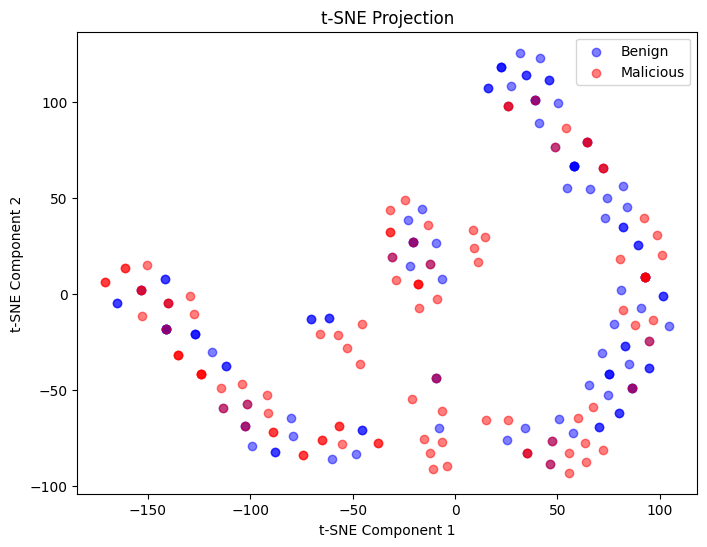

Total Number of Points: 224
Number of Overlapping Points: 54
% Ambiguous Points: 24.107142857142858
% Max Accuracy: 75.89285714285714


In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Print out the t-SNE transformed coordinates
print("t-SNE Transformed Coordinates:")
print(X_tsne)

# Plot the reduced-dimensional data
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['b', 'r']  # Assuming binary target classes

# Initialize lists to store point coordinates for each class
class_0_points = []
class_1_points = []

for target, color in zip(targets, colors):
    class_label = 'Benign' if target == 0 else 'Malicious'
    plt.scatter(X_tsne[y == target, 0], X_tsne[y == target, 1], c=color, label=class_label, alpha=0.5)

    # Store point coordinates for each class
    class_points = list(zip(X_tsne[y == target, 0], X_tsne[y == target, 1]))
    if target == 0:
        class_0_points.extend(class_points)
    else:
        class_1_points.extend(class_points)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection')
plt.legend()
plt.show()

# Calculate the total number of points
total_points = len(class_0_points) + len(class_1_points)
print(f"Total Number of Points: {total_points}")

# Calculate the number of overlapping points
overlapping_points = 0
for point_0 in class_0_points:
    for point_1 in class_1_points:
        if point_0 == point_1:
            overlapping_points += 1

print(f"Number of Overlapping Points: {overlapping_points}")

percentageA = overlapping_points/total_points
print(f"% Ambiguous Points: {percentageA*100}")
print(f"% Max Accuracy: {(1 - percentageA)*100}")

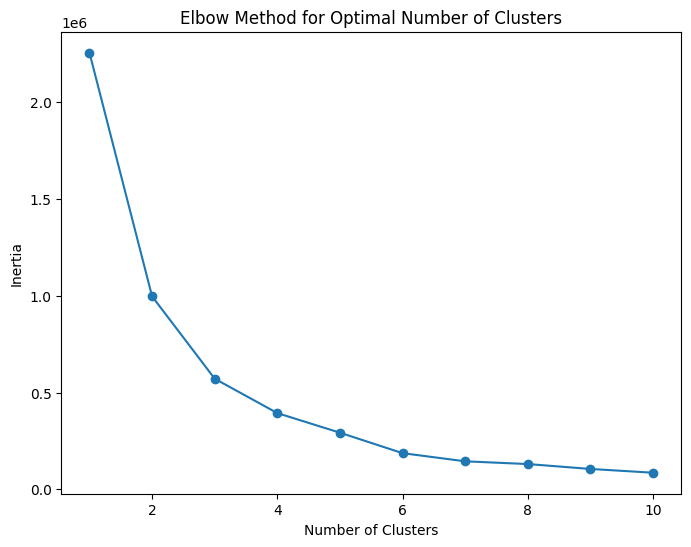

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Initialize a figure
plt.figure(figsize=(8, 6))

# Define the range of clusters to try
num_clusters_range = range(1, 11)  # Try cluster numbers from 1 to 10

# Initialize list to store inertia values (sum of squared distances to the nearest cluster center)
inertia_values = []

# Iterate over the range of clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_tsne)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(num_clusters_range, inertia_values, marker='o')

# Add labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')

# Show plot
plt.show()


Total Overlap Area: 2890.6762759970447
Total Area: 15685.564786828385
Overlap Percentage: 18.43%
Estimated Accuracy: 81.57%

Cluster Counts per Class:
Class 0 (Benign): 8 clusters
Class 1 (Malicious): 8 clusters

Number of Overlapping Clusters: 12

Grand Total of Clusters: 16


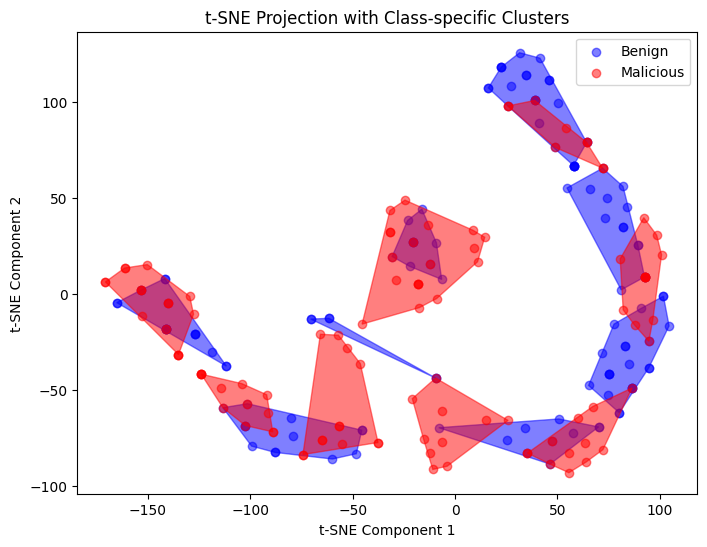

In [50]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from shapely import MultiPolygon
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon as ShapelyPolygon
from matplotlib.patches import Polygon

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Define the number of clusters for each class
num_clusters_per_class = 8
# Initialize a figure
plt.figure(figsize=(8, 6))

# Define colors for each class
class_colors = {0: 'blue', 1: 'red'}

# Initialize lists to store polygons for each class
class_0_polygons = []
class_1_polygons = []

# Iterate over unique classes
for target_class in np.unique(y):
    # Filter the data points for the current class
    X_class = X_tsne[y == target_class]

    # Apply K-means clustering within the current class
    kmeans = KMeans(n_clusters=num_clusters_per_class, random_state=42)
    clusters = kmeans.fit_predict(X_class)

    # Plot the data points within the current class
    class_label = 'Benign' if target_class == 0 else 'Malicious'
    plt.scatter(X_class[:, 0], X_class[:, 1], label=class_label, color=class_colors[target_class], alpha=0.5)

    # Plot the polygons for each cluster and store them in the corresponding list
    for cluster in range(num_clusters_per_class):
        cluster_points = X_class[clusters == cluster]
        hull = ConvexHull(cluster_points)
        polygon = Polygon(cluster_points[hull.vertices], fill=True, edgecolor=class_colors[target_class],
                          facecolor=class_colors[target_class], alpha=0.5)
        plt.gca().add_patch(polygon)
        if target_class == 0:
            class_0_polygons.append(ShapelyPolygon(cluster_points[hull.vertices]))
        else:
            class_1_polygons.append(ShapelyPolygon(cluster_points[hull.vertices]))

# Calculate the total overlap area
total_overlap_area = 0
overlapping_clusters = []
for poly_0 in class_0_polygons:
    for poly_1 in class_1_polygons:
        intersection = poly_0.intersection(poly_1)
        if not intersection.is_empty:
            total_overlap_area += intersection.area
            overlapping_clusters.append((poly_0, poly_1))

# Calculate the total area covered by all the polygons
all_polygons = class_0_polygons + class_1_polygons
multi_polygon = MultiPolygon(all_polygons)
total_area = multi_polygon.area

# Calculate the overlap percentage
overlap_percentage = (total_overlap_area / total_area) * 100
estimated_accuracy = 100 - overlap_percentage

# Print results
print("Total Overlap Area:", total_overlap_area)
print("Total Area:", total_area)
print("Overlap Percentage: {:.2f}%".format(overlap_percentage))
print("Estimated Accuracy: {:.2f}%".format(estimated_accuracy))

# Print cluster counts per class
print("\nCluster Counts per Class:")
print(f"Class 0 (Benign): {len(class_0_polygons)} clusters")
print(f"Class 1 (Malicious): {len(class_1_polygons)} clusters")

# Print the number of overlapping clusters
print(f"\nNumber of Overlapping Clusters: {len(overlapping_clusters)}")

# Calculate the grand total of clusters
grand_total_clusters = len(class_0_polygons) + len(class_1_polygons)
print(f"\nGrand Total of Clusters: {grand_total_clusters}")

# Set plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection with Class-specific Clusters')
plt.legend()

# Show plot
plt.show()

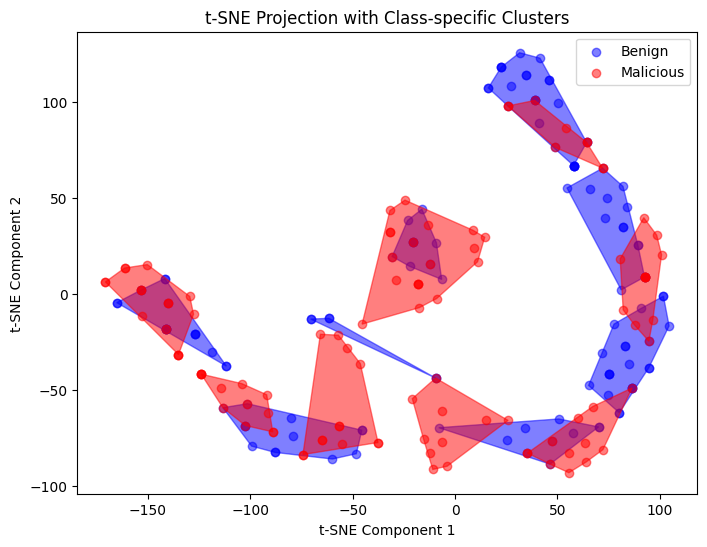

In [51]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from shapely import MultiPolygon
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon as ShapelyPolygon
from matplotlib.patches import Polygon
import matplotlib.animation as animation

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Define the number of clusters for each class
num_clusters_per_class = 8

# Define colors for each class
class_colors = {0: 'blue', 1: 'red'}

# Initialize lists to store polygons for each class
class_0_polygons = []
class_1_polygons = []

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize lists to store artists
scatter_plots = []
polygon_artists = []

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title('t-SNE Projection with Class-specific Clusters')

    # Iterate over unique classes
    for target_class in np.unique(y):
        # Filter the data points for the current class
        X_class = X_tsne[y == target_class]

        # Apply K-means clustering within the current class
        kmeans = KMeans(n_clusters=num_clusters_per_class, random_state=42)
        clusters = kmeans.fit_predict(X_class)

        # Plot the data points within the current class
        class_label = 'Benign' if target_class == 0 else 'Malicious'
        scatter = ax.scatter(X_class[:, 0], X_class[:, 1], label=class_label, color=class_colors[target_class], alpha=0.5)
        scatter_plots.append(scatter)

        # Plot the polygons for each cluster and store them in the corresponding list
        for cluster in range(num_clusters_per_class):
            cluster_points = X_class[clusters == cluster]
            hull = ConvexHull(cluster_points)
            polygon = Polygon(cluster_points[hull.vertices], fill=True, edgecolor=class_colors[target_class],
                               facecolor=class_colors[target_class], alpha=0.5)
            polygon_artist = ax.add_patch(polygon)
            polygon_artists.append(polygon_artist)
            if target_class == 0:
                class_0_polygons.append(ShapelyPolygon(cluster_points[hull.vertices]))
            else:
                class_1_polygons.append(ShapelyPolygon(cluster_points[hull.vertices]))

    ax.legend()

    # Return the list of artists to be animated
    return scatter_plots + polygon_artists

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=10, blit=True)

# Save the animation as an MP4 file
ani.save('animation.mp4', writer='ffmpeg', fps=2)